<a href="https://colab.research.google.com/github/ricejohn03/CNN-Pneumonia-Xray/blob/master/XrayCNN_Transfer_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import keras
import os
import tensorflow as tf
from keras import backend as k
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import*
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint

np.random.seed(23)


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


4/OwH2nPymmTlYglCa5NE79ECINZ1UC4ysGS5dMtqKBYMQ-UJg4g34-Og

In [ ]:
train_path = 'gdrive/My Drive/ML_Data/X-ray-pneumonia/train'
valid_path = 'gdrive/My Drive/ML_Data/X-ray-pneumonia/val'
test_path  = 'gdrive/My Drive/ML_Data/X-ray-pneumonia/test'

In [ ]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['NORMAL','PNEUMONIA'], batch_size=5, shuffle=True)


Found 5216 images belonging to 2 classes.


In [ ]:
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['NORMAL','PNEUMONIA'], batch_size=5)


Found 285 images belonging to 2 classes.


In [ ]:
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['NORMAL','PNEUMONIA'], batch_size=5)

Found 355 images belonging to 2 classes.


In [ ]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False)
x=resnet_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
preds=Dense(2,activation='softmax')(x)

W0727 15:26:38.115721 139854238406528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 15:26:38.160029 139854238406528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 15:26:38.174476 139854238406528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0727 15:26:38.214591 139854238406528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0727 15:26:38.215964

94658560/94653016 [==============================] - 2s 0us/step


In [ ]:
model = Model(inputs=resnet_model.input, outputs=preds)

In [ ]:
for layer in model.layers[:20]:
  layer.trainable = False
for layer in model.layers[20:]:
  layer.trainable = True

In [ ]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
step_size_train = train_batches.n//train_batches.batch_size
step_size_valid = valid_batches.n//valid_batches.batch_size

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_path = "gdrive/My Drive/ML_Data/X-ray-pneumonia/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True, save_best_only=True,
                                                 verbose=1)
history = model.fit_generator(train_batches, steps_per_epoch=step_size_train, 
                   validation_data=valid_batches, validation_steps=step_size_valid,callbacks=[cp_callback], epochs=3, verbose=2)

W0727 15:27:17.802408 139854238406528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0727 15:27:17.966185 139854238406528 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/3
 - 1607s - loss: 0.6369 - acc: 0.8077 - val_loss: 1.8746 - val_acc: 0.4842

Epoch 00001: val_loss improved from inf to 1.87460, saving model to gdrive/My Drive/ML_Data/X-ray-pneumonia/cp.ckpt
Epoch 2/3
 - 109s - loss: 0.3224 - acc: 0.8460 - val_loss: 0.7194 - val_acc: 0.5509

Epoch 00002: val_loss improved from 1.87460 to 0.71935, saving model to gdrive/My Drive/ML_Data/X-ray-pneumonia/cp.ckpt
Epoch 3/3
 - 110s - loss: 0.2731 - acc: 0.8813 - val_loss: 8.3135 - val_acc: 0.4842

Epoch 00003: val_loss did not improve from 0.71935


AttributeError: ignored

In [ ]:
# Restore the weights
model.load_weights('gdrive/My Drive/ML_Data/X-ray-pneumonia/cp.ckpt')


print("Restored Best model")

Restored Best model


In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


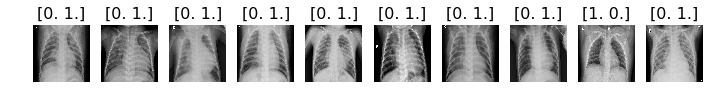

In [ ]:
test_img , test_labels = next(test_batches)
plots(test_img, titles=test_labels)

In [ ]:
test_labels = test_labels[:,0]
test_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
predictions = model.predict_generator(test_batches,steps=1,verbose=0)

In [ ]:
predictions  

array([[0.7259355 , 0.27406448],
       [0.19884121, 0.8011587 ],
       [0.6947125 , 0.30528748],
       [0.4673113 , 0.5326887 ],
       [0.12669902, 0.87330097],
       [0.9964246 , 0.00357536],
       [0.20880717, 0.7911928 ],
       [0.18987936, 0.81012064],
       [0.9921523 , 0.00784773],
       [0.16803613, 0.83196384]], dtype=float32)

In [ ]:
pred_array = np.argmax(predictions, axis=1)
pred_array

array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1])

In [ ]:
len(pred_array)

10